# Analysis of GSE12290

Tong Shu Li

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from scipy.stats import linregress

In [2]:
%matplotlib inline

In [3]:
sys.path.append("..")

In [4]:
from src.plots import plot_multi_density
from src.plots import config_plot

---

## Read GSE12290 data

In [5]:
data = pd.read_csv("../data/GSE12290/filtered_expression.tsv", sep = '\t')

In [6]:
data.shape

(1330160, 9)

In [7]:
data.head()

,probe_id,log2_exp,orf_id,wormbase_id,gene_symbol,title,geo_accession,days_old,behavior
0,cea2.3.00017,0.026223,AC3.2,WBGene00007070,ugt-49,tg10,GSM308821,8,A
1,cea2.3.00017,0.013543,AC3.2,WBGene00007070,ugt-49,tg100,GSM308822,4,A
2,cea2.3.00017,-0.961007,AC3.2,WBGene00007070,ugt-49,tg109,GSM308823,8,A
3,cea2.3.00017,-0.829387,AC3.2,WBGene00007070,ugt-49,tg101,GSM308824,14,A
4,cea2.3.00017,-0.838482,AC3.2,WBGene00007070,ugt-49,tg102,GSM308825,24,C


---

## Explore expression distributions

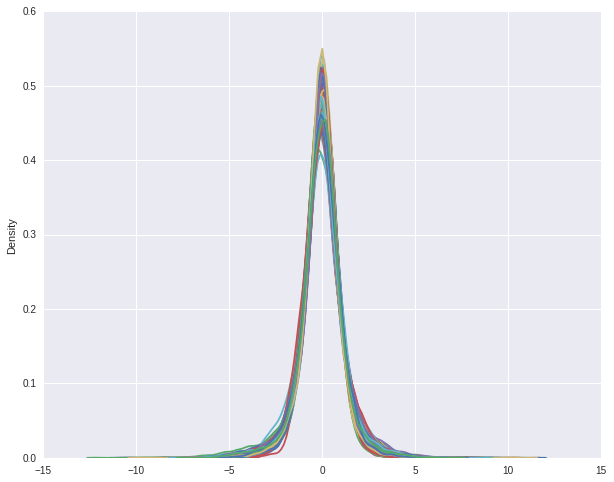

In [8]:
ax = plot_multi_density(
    data, "geo_accession", "log2_exp",
    rc = {"figure.figsize": (10, 8)}
)

ax.legend().set_visible(False)

The x axis value here does not seem to be the gene's log2 intensity of the brightness. If it was, then a value of -10 would be barely detectable on a microarray.

Since the mean of the distribution lies at zero, and the distribution is symmetric, it therefore seems that this is the normalized log fold expression change of each sample with respect to the pooled expression of the day 4 worms. If this was the raw expression value, then we would not expect a symmetric distribution. With this in mind, we should be able to go directly to the drift calculations.

In [9]:
# relative log fold expression change
data = data.rename(columns = {"log2_exp": "RLFEC"})

## Calculating drift

In [10]:
drift = (
    data.groupby(["geo_accession", "days_old", "behavior"], as_index = False)
        .agg({"RLFEC": np.var})
        .rename(columns = {"RLFEC": "drift"})
).sort_values(["days_old", "behavior"])

In [11]:
drift.shape

(104, 4)

In [12]:
drift.head()

,geo_accession,days_old,behavior,drift
1,GSM308822,4,A,1.127656
11,GSM308832,4,A,1.017992
12,GSM308833,4,A,0.898422
20,GSM308841,4,A,0.880579
24,GSM308845,4,A,0.900121


---

## Plot drift trends for all three types of movement phenotypes

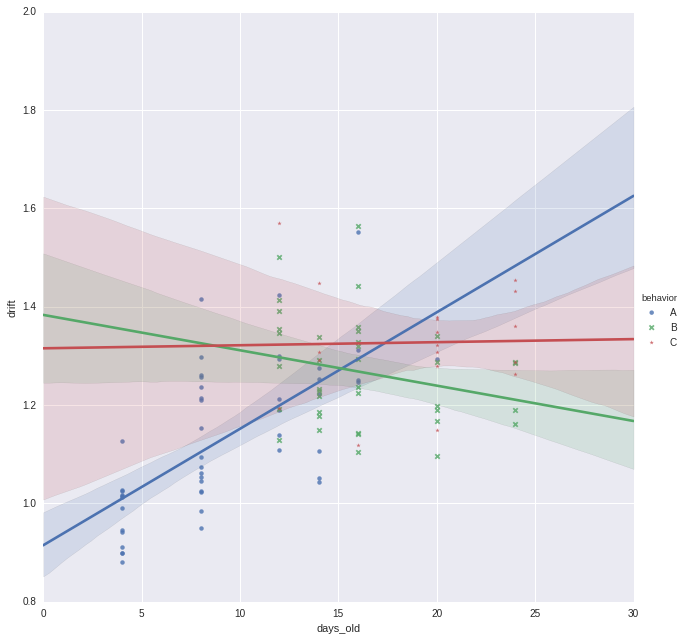

In [13]:
sns.lmplot(
    data = drift,
    x = "days_old", y = "drift",
    hue = "behavior",
    size = 9,
    markers = ['o', 'x', '*']
);

### Plot drift but without grouping based on phenotype

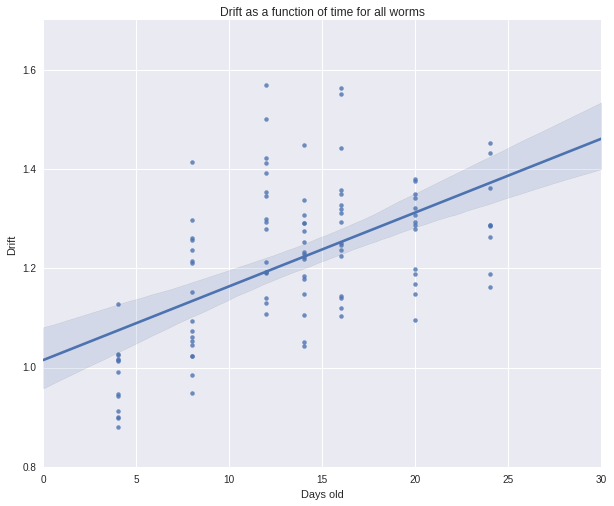

In [14]:
@config_plot
def jek(**kwargs):
    return sns.regplot(
        data = drift,
        x = "days_old", y = "drift"
    )

ax = jek(rc = {"figure.figsize": (10, 8)})
ax.set_title("Drift as a function of time for all worms")
ax.set_ylabel("Drift")
ax.set_xlabel("Days old")

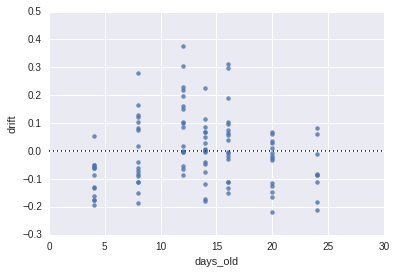

In [15]:
sns.residplot(data = drift, x = "days_old", y = "drift");

### Fit a binomial regression instead

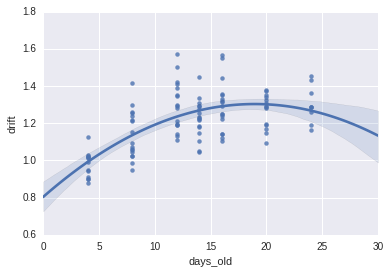

In [16]:
sns.regplot(
    data = drift,
    x = "days_old", y = "drift",
    order = 2
);

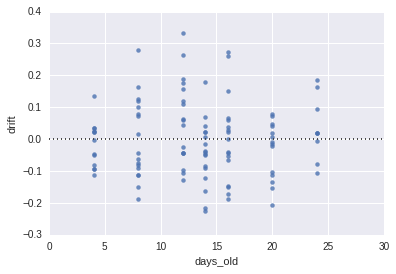

In [17]:
sns.residplot(data = drift, x = "days_old", y = "drift", order = 2);

Seems like the residuals of the binomial regression fit better?

### Observe each phenotype separately

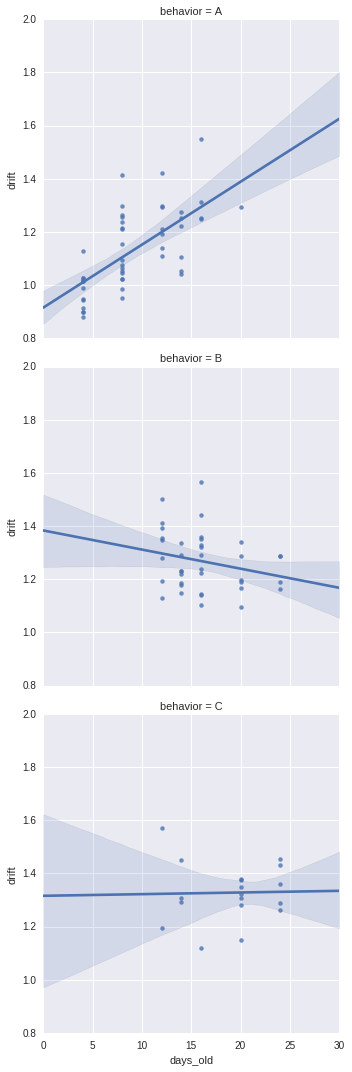

In [18]:
sns.lmplot(
    data = drift,
    x = "days_old", y = "drift",
    row = "behavior"
);